# Выделение слов на изображении с текстом

## Подключение библиотек

In [1]:
import pytesseract
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import utils

pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

## Tesseract

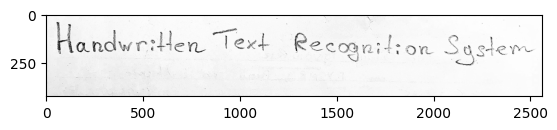

In [3]:
image = cv.imread('./samples/HTR.png', cv.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

In [4]:
from preprocessing import DataPreprocessor

In [5]:
preprocessor = DataPreprocessor(*image.shape)
im_1, im_2, im_3 = preprocessor(image)

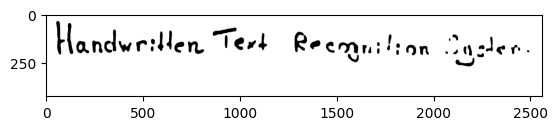

In [6]:
plt.imshow(im_3, cmap='gray')
plt.show()

In [7]:
boxes = pytesseract.image_to_boxes(image, lang='eng')
print(boxes)

e 640 225 714 272 0
Y 722 217 765 303 0
L 733 221 826 277 0
| 926 242 934 310 0
@ 973 241 1025 295 0
x 1038 241 1086 288 0
} 635 279 649 335 0
4 619 249 648 278 0
# 639 234 646 246 0
& 540 268 563 288 0
@ 543 233 555 254 0
H 54 215 227 379 0
e 240 225 297 280 0
l 300 227 524 338 0



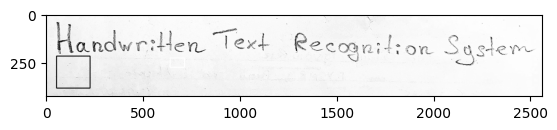

In [13]:
image = cv.rectangle(image, (54, 215), (227, 379), (0, 0, 0), 3)
plt.imshow(image, cmap='gray')
plt.show()

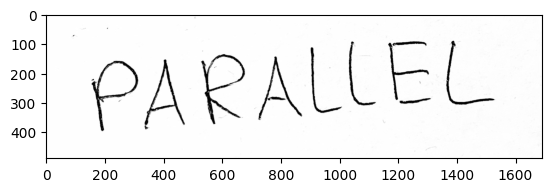

In [3]:
par = cv.imread('./samples/parallel.png', cv.IMREAD_GRAYSCALE)

plt.imshow(par, cmap='gray')
plt.show()

In [4]:
print(pytesseract.image_to_string(par))

PARALLEL



То есть Tesseract подходит для распознавания печатных символов, но не справляется с рукописными совершенно.

## OpenCV

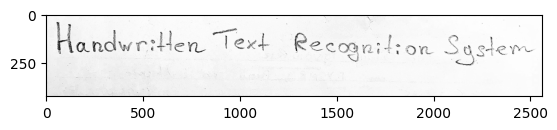

In [59]:
image = cv.imread('./samples/HTR.png', cv.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()


In [60]:
def calc_kernel_size(med_line: int, percent: float) -> int:
    kernel_size = int(percent * med_line)
    kernel_size += ((kernel_size & 1) + 1) & 1
    return kernel_size


def calc_gaussian_kernel_size(med_line: int, percent: float) -> int:
    kernel_size = calc_kernel_size(med_line, percent)
    return kernel_size if kernel_size > 1 else 3


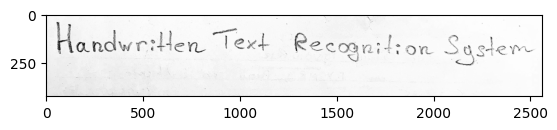

In [63]:
blur_kernel = (calc_gaussian_kernel_size(
    image.shape[0], 0.0025), calc_gaussian_kernel_size(image.shape[1], 0.00125))
image_blur = cv.GaussianBlur(image, ksize=blur_kernel, sigmaX=0)
plt.imshow(image_blur, cmap='gray')
plt.show()


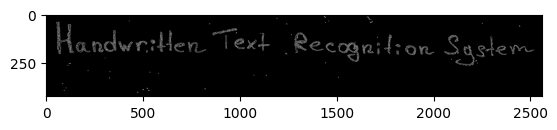

In [64]:
threshold = 100
canny_output = cv.Canny(image_blur, 100, 255)
plt.imshow(canny_output, cmap='gray')
plt.show()


In [104]:
boxes = pytesseract.image_to_boxes(canny_output)
print(len(boxes))

drawing = np.zeros(
    (canny_output.shape[0], canny_output.shape[1], 1), dtype=np.uint8)

for i in range(len(boxes)):
    drawing = cv.rectangle(drawing, (int(boxes[i][1]), int(boxes[i][2])),
                           (int(boxes[i][3]), int(boxes[i][4])), (255, 0, 0), 2)

plt.imshow(drawing, cmap='gray')
plt.show()


102


IndexError: string index out of range

[(469, 399, 1, 1), (527, 390, 1, 1), (96, 389, 1, 1), (504, 385, 1, 1), (818, 382, 1, 1), (522, 378, 1, 1), (104, 377, 1, 1), (84, 355, 1, 1), (326, 326, 1, 1), (1508, 322, 1, 1), (1135, 312, 1, 1), (1072, 311, 1, 1), (579, 303, 1, 1), (535, 296, 1, 1), (328, 294, 1, 1), (215, 288, 1, 1), (2183, 264, 1, 1), (2164, 263, 1, 1), (2154, 262, 1, 1), (111, 261, 1, 1), (2198, 258, 1, 1), (2136, 258, 1, 1), (127, 251, 1, 1), (2225, 249, 1, 1), (1444, 248, 1, 1), (1605, 238, 1, 1), (2223, 237, 1, 1), (1613, 235, 1, 1), (2092, 230, 1, 1), (1605, 228, 1, 1), (304, 224, 1, 1), (1612, 220, 1, 1), (1570, 220, 1, 1), (1562, 219, 1, 1), (1608, 214, 1, 1), (2262, 213, 1, 1), (1569, 213, 1, 1), (1576, 211, 1, 1), (2099, 206, 1, 1), (2082, 206, 1, 1), (1582, 211, 1, 1), (1575, 205, 1, 1), (1556, 210, 58, 28), (2304, 205, 1, 1), (2068, 202, 1, 1), (2115, 203, 1, 1), (1713, 200, 1, 1), (2196, 199, 1, 1), (1235, 199, 1, 1), (1664, 198, 1, 1), (65, 198, 1, 1), (1862, 197, 1, 1), (2066, 196, 1, 1), (1475, 196

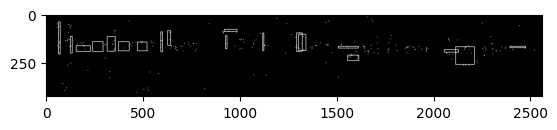

()


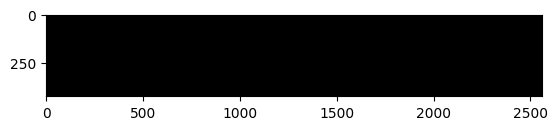

In [100]:
contours, _ = cv.findContours(
    canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
boundRect = [None]*len(contours)

for i, c in enumerate(contours):
    contours_poly = cv.approxPolyDP(c, min(image.shape)*0.15, True)
    boundRect[i] = cv.boundingRect(contours_poly)

print(boundRect)
drawing = np.zeros(
    (canny_output.shape[0], canny_output.shape[1], 1), dtype=np.uint8)

for i in range(len(boundRect)):
    drawing = cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])),
                           (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (255, 0, 0), 2)

plt.imshow(drawing, cmap='gray')
plt.show()


rect, _ = cv.groupRectangles(boundRect, 10, eps=5)
print(rect)

drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 1), dtype=np.uint8)

for i in range(len(rect)):
    drawing = cv.rectangle(drawing, (int(rect[i][0]), int(rect[i][1])),
                           (int(rect[i][0]+rect[i][2]), int(rect[i][1]+rect[i][3])), (255, 0, 0), 2)

plt.imshow(drawing, cmap='gray')
plt.show()

## Cropping

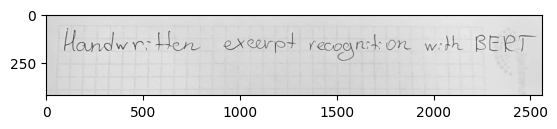

In [61]:
image = cv.imread('./samples/HerBERT.png', cv.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

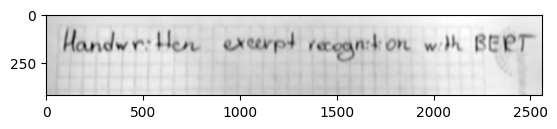

In [62]:
blur_kernel = (utils.calc_gaussian_kernel_size(
    image.shape[0], 0.075), utils.calc_gaussian_kernel_size(image.shape[1], 0.02))
image_blur = cv.GaussianBlur(image, ksize=blur_kernel, sigmaX=0)
plt.imshow(image_blur, cmap='gray')
plt.show()


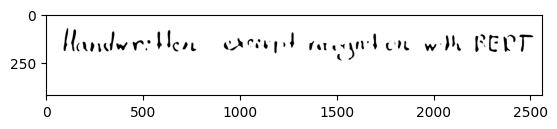

In [63]:
# _, image_bin = cv.threshold(image_blur, 220, 255,  cv.THRESH_OTSU)
image_bin = cv.adaptiveThreshold(image_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, utils.calc_gaussian_kernel_size(
    max(image.shape), min(image.shape)/max(image.shape) * 0.25), C=10)
plt.imshow(image_bin, cmap='gray')
plt.show()


In [64]:
empty_columns = (image_bin == 255).all(axis=0)


22.0
[ 107  155  237  299  374  464  538  575  621  661  731  857 1038 1095
 1281 1362 1423 1443 1508 1632 1705 1747 1805 1856 1926 2055 2222 2269
 2323 2393 2465]
[ 102  147  229  295  368  453  529  568  613  656  722  839 1030 1089
 1213 1354 1422 1438 1500 1623 1693 1735 1794 1842 1918 2021 2217 2266
 2314 2382 2457]
[  9  16  16   7  12  22  17  13  16  10  18  36  16  11 136  15   2   9
  16  18  24  23  21  28  16  67  10   5  17  21  15]
[ 839 1213 1693 1735 1842 2021 2560]
(8,)


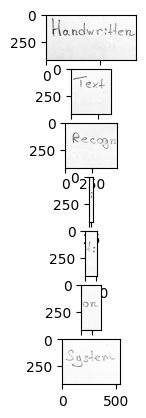

In [170]:
lens, elems, inds = rle(empty_columns)
mid = np.append(0, ((inds[1:]+inds[:-1])/2).astype(int))
lens, inds, mid = lens[elems==True], inds[elems==True], mid[elems==True]

lens, inds, mid = lens[1:-1], inds[1:-1], mid[1:-1]
mn = np.quantile(lens, 0.8)
print(mn)

print(inds)
print(mid)
print(lens)

inds = mid[lens > mn]
inds = np.append(inds, image.shape[1])

print(inds)

_, axs = plt.subplots(nrows=inds.shape[0], ncols=1)
inds = np.append(0, inds)

print(inds.shape)

for i in range(1, inds.shape[0]):
    axs[i-1].imshow(image[:, inds[i-1]:inds[i]], cmap='gray')

plt.show()


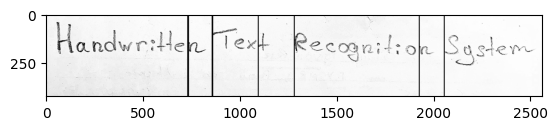

In [151]:
drawing = np.zeros(
    (image.shape[0], image.shape[1], 1), dtype=np.uint8)
drawing = cv.rectangle(image, (1281, 0), (1281, image.shape[0]), (0, 0, 0), 3)
plt.imshow(drawing, cmap='gray')
plt.show()

In [65]:
import datetime 
words_number = 5

lens, elems, inds = utils.find_consecutive(empty_columns)
spaces_medians = np.append(0, ((inds[1:]+inds[:-1])/2).astype(int))
lens, spaces_medians = lens[elems == True], spaces_medians[elems == True]
lens, spaces_medians = lens[1:-1], spaces_medians[1:-1]

st = datetime.datetime.now()
zipped = zip(lens, spaces_medians)
zipped = sorted(zipped, key=lambda pair: pair[0])
en = (datetime.datetime.now() - st).total_seconds()
print(zipped)
print(en)

bounds = np.array(zipped[-words_number+1:])
# bounds = bounds[:, 1].sort()
bounds = bounds[:, 1]
bounds.sort()
print(bounds)

st = datetime.datetime.now()
zipped = np.stack((lens, spaces_medians), axis=1)
zipped = zipped[zipped[:, 0].argsort()]
en = (datetime.datetime.now() - st).total_seconds()
# print(zipped)
print(en)

bounds = zipped[np.diff(zipped[:, 0]).argmax():, 1]
bounds.sort()
print(bounds)


[(1, 521), (1, 1257), (1, 1796), (1, 2513), (2, 155), (6, 325), (6, 1499), (6, 2235), (7, 1146), (8, 1791), (9, 1594), (9, 2114), (10, 357), (10, 508), (10, 1424), (10, 1619), (12, 290), (12, 647), (12, 1075), (13, 220), (13, 1808), (15, 121), (15, 180), (15, 1390), (15, 1839), (15, 2088), (16, 1648), (17, 257), (17, 738), (18, 694), (18, 1114), (19, 2432), (20, 1168), (20, 1551), (20, 2276), (21, 1245), (21, 2024), (21, 2049), (22, 1676), (24, 1027), (26, 2347), (27, 432), (27, 610), (30, 1208), (31, 1462), (34, 555), (46, 1730), (75, 2177), (79, 1318), (81, 1914), (142, 846)]
0.0
[ 846 1318 1914 2177]
0.0
[ 846 1914]


In [180]:
print(image.shape)

(420, 2560)


# Обрезание текста

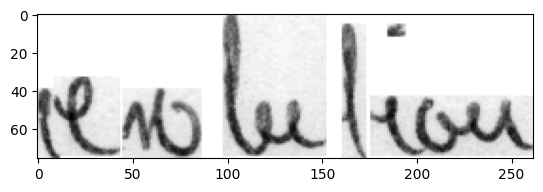

In [250]:
image = cv.imread('./samples/rev.png', cv.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

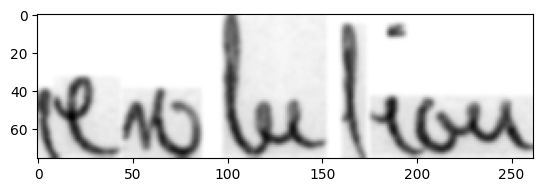

In [251]:
blur_kernel = (calc_gaussian_kernel_size(
    image.shape[0], 0.075), calc_gaussian_kernel_size(image.shape[1], 0.02))
image_blur = cv.GaussianBlur(image, ksize=blur_kernel, sigmaX=0)
plt.imshow(image_blur, cmap='gray')
plt.show()


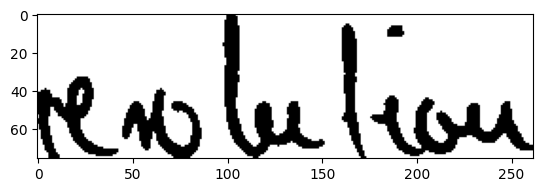

In [258]:
_, image_bin = cv.threshold(image_blur, 220, 255,  cv.THRESH_OTSU)
plt.imshow(image_bin, cmap='gray')
plt.show()


In [259]:
temp_image = np.full(shape=[image_bin.shape[0]+2,
                     image_bin.shape[1]+2], fill_value=255, dtype=np.uint8)
temp_image[1:-1, 1:-1] = image_bin

In [261]:
empty_columns = (temp_image == 255).all(axis=0)
print(empty_columns)

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True  True  True  True  True False False Fa

[  0  43  45  87  98 152 161 174 176 262 263]
[ True False  True False  True False  True False  True False  True]
0
262


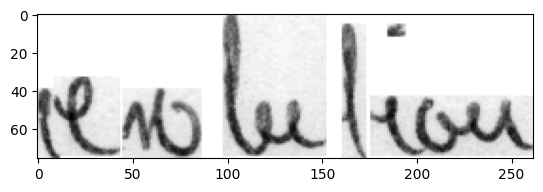

In [262]:
_, elems, inds = rle(empty_columns)

print(inds)
print(elems)

left_column = inds[elems == True][0]
print(left_column)
right_column = inds[elems==False][-1]
print(right_column)

plt.imshow(image[:, left_column:right_column+1], cmap='gray')
plt.show()


In [263]:
empty_rows = (temp_image == 255).all(axis=1)

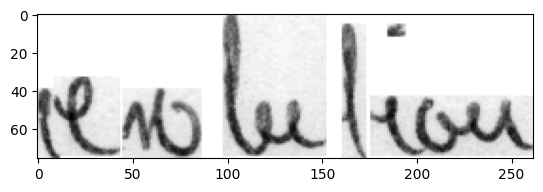

In [264]:
_, elems, inds = rle(empty_rows)
upper_row = np.append(inds[elems == True], 0)[0]
lower_row = inds[elems == False][-1]

plt.imshow(image[upper_row:lower_row+1, left_column:right_column+1], cmap='gray')
plt.show()


In [266]:
temp_image = np.full(shape=[image_bin.shape[0]+2, image_bin.shape[1]+2], fill_value=255, dtype=np.uint8)
temp_image[1:-1, 1:-1] = image_bin

lens, elems, _ = rle(temp_image.ravel())
h_stroke_len = int(np.median(lens[elems==0]))
print(h_stroke_len)

lens, elems, _ = rle(temp_image.T.ravel())
v_stroke_len = int(np.median(lens[elems == 0]))
print(v_stroke_len)


7
8


## Smth

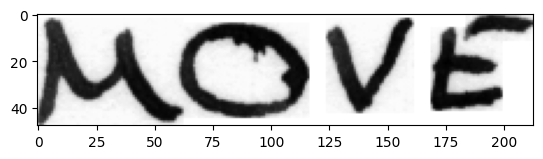

In [3]:
image = cv.imread('./samples/move.png', cv.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

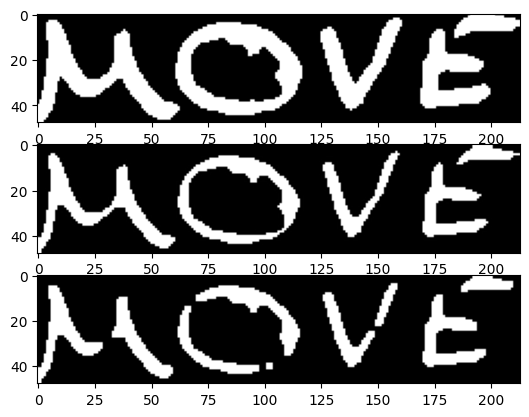

In [5]:
from preprocessing import WordPreprocessor

preprocessor = WordPreprocessor(*image.shape)

images = preprocessor(image)

_, axs = plt.subplots(nrows=len(images), ncols=1)
for i, sample in enumerate(images):
    axs[i].imshow(sample, cmap='gray')
plt.show()